# Week 4 Mini Project: RNN Disaster Tweets Classification

By: Jaeyoung Oh

Repo: https://github.com/BlueJayVRStudio/CSCA5642_Week4

## Problem Statement

The objective of this week's mini project is to classify the context of Tweets. It is a simple binary classification between whether it is about real disasters or not. The set of data consists of a training set and a test set. The test set is reserved only for submission and not validation. The training set consists of 7613 hand-classified data points each composed of ID, keyword, location, body of text and target label. We will first explore keyword, location and text body to identify potential input columns and then perform necessary preprocessing steps on the selected input.

### Import Modules

In [16]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

Num GPUs Available: 1


## EDA

In [17]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [20]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


ID has no special meaning, so we can easily drop ID from the dataset. Additionally, there are too many null values in keyword and location. Keyword is selected word from the text so it is redudant information. Although location might provide some special context, there are too many null values and does not contain too much meaning. Therefore, we really only need to consider the text bodies as our input column. 

Now we will do some basic NLP preprocessing. *Here are some considerations*:
1. Most NLP tasks favor removing stop words and porter stemming, but for complex context dependent tasks like identifying real disaster in a tweet, preservation of stop words and suffixes may be quintessential especially taking into account the fact that RNN's can discern sequential/temporal patterns.
2. Because RNN learns sequential information, we have to use word tokens as opposed to vectors. We may also use a pretrained word embedding such as Word2Vec.
3. URL's don't provide enough contextual clues and unnecessarily increase complexity. Thus, we can easily decide to remove URL's.
4. For similar reason to removing URL's we can convert all texts to lowercase.

In [21]:
import re

def clean_text(text):
    # remove url's (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # convert to lowercase
    text = text.lower()
    return text

# try removing stopwords and suffixes as well
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text_V1(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)
    

In [22]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [23]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


*Next we look at class distribution to make sure there isn't too much class imbalance*:

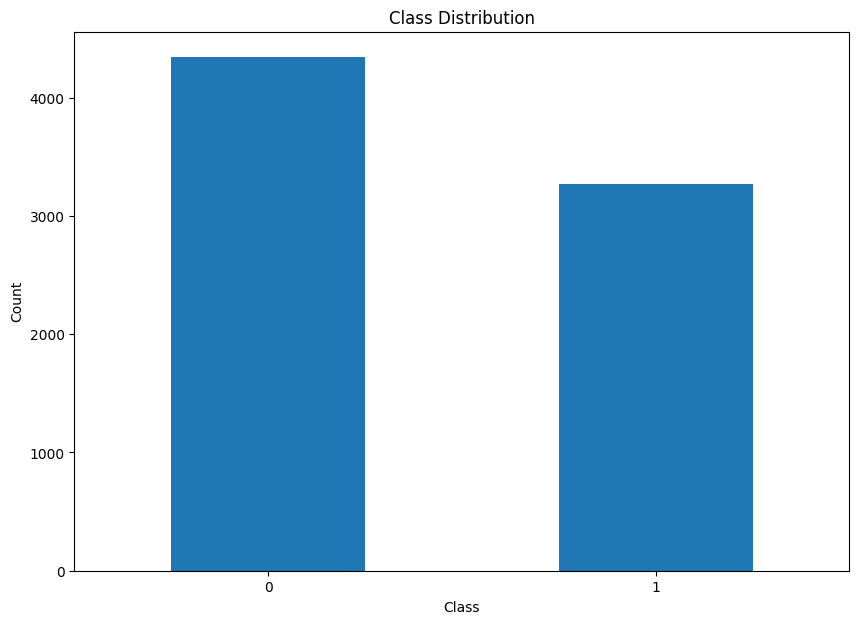

In [24]:
def plot_class_distribution(labels):
    class_counts = labels.value_counts()
    
    plt.figure(figsize=(10, 7))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

plot_class_distribution(train_df['target'])

### Prepare Embedding Matrix (using word2vec)

In [25]:
word2vec = KeyedVectors.load_word2vec_format('./embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [26]:
# maximum number of words in a text
max_sequence_length = 50  
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(train_df['text'])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')

In [27]:
# test set for submission
sequences_test = tokenizer.texts_to_sequences(test_df['text'])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

In [28]:
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

# embedding_matrix

### Train-Validation Splits

In [29]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences_train, train_df['target'], test_size=0.2, random_state=0)

### EDA Conclusion

For this EDA, we first assessed that our input will consist only of the text column, as the keyword and the location columns do not provide meaningful context and contain numerous null values in an already sparse dataset. Then we determined that we will only remove URL's and convert the text to lowercase. We will refrain from removing the stop words and suffixes, as RNN architectures will be able to make use of contextual clues provided by stopwords and suffixes. Furthermore, we also confirmed that the class labels are fairly balanced and no further balance is needed. Lastly, we tokenized our training, validation and test text inputs and created a word embedding matrix to enhance our RNN models.

## Model Building

For our models, we will try three different architecture involving GRU, LSTM and pre-trained BERT. For untuned GRU and LSTM, we will set the units to 32, follow up with a dense layer with 128 neurons with a relu activation and finally end with a dense classifier layer with 1 neuron and sigmoid activation. We will set the learning rate to 0.001 with an Adam optimizer. For LSTM hyperparameter tuning, we will design the model to have 16 units instead, add dropout regularization in between the layers and then lower the learning rate to 0.0001. Finally, we will try to compare our RNN models with a transformer model by using a pre-trained BERT from the transformers module.

### Model Performance Plot and ROC Curve (Helper Functions)

In [89]:
def plot_accuracy(hist, name):
    hist_train = hist.history['accuracy']
    hist_val = hist.history['val_accuracy']

    plt.figure(figsize=(11, 7))

    plt.plot(range(len(hist_train)), hist_train, marker='o', label = 'accuracy, training')
    plt.plot(range(len(hist_train)), hist_val, marker='o', label = 'accuracy, validation')
    
    plt.xticks(range(len(hist_train)), range(len(hist_train)), rotation=45)
    
    plt.legend() 
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(name)
    plt.grid(True)
    plt.show()

In [90]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
    plt.title(name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

### GRU without Hyperparameter Tuning

In [91]:
# build GRU model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),

    GRU(32, return_sequences=False, trainable=True),
    # Dropout(0.2),
    Dense(128, activation='relu', trainable=True),
    # Dropout(0.2),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 gru_4 (GRU)                 (None, 32)                32064     
                                                                 
 dense_14 (Dense)            (None, 128)               4224      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5464617 (20.85 MB)
Trainable params: 36417 (142.25 KB)
Non-trainable params: 5428200 (20.71 MB)
_________________________________________________________________


In [92]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
191/191 [==============================] - 10s 18ms/step - loss: 0.6854 - accuracy: 0.5678 - val_loss: 0.6808 - val_accuracy: 0.5817
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.6841 - accuracy: 0.5675 - val_loss: 0.6799 - val_accuracy: 0.5817
Epoch 3/100
191/191 [==============================] - 3s 14ms/step - loss: 0.6005 - accuracy: 0.6741 - val_loss: 0.5045 - val_accuracy: 0.7689
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.4488 - accuracy: 0.8077 - val_loss: 0.4528 - val_accuracy: 0.8024
Epoch 5/100
191/191 [==============================] - 3s 15ms/step - loss: 0.4143 - accuracy: 0.8273 - val_loss: 0.4725 - val_accuracy: 0.8083
Epoch 6/100
191/191 [==============================] - 3s 15ms/step - loss: 0.3919 - accuracy: 0.8396 - val_loss: 0.4322 - val_accuracy: 0.8076
Epoch 7/100
191/191 [==============================] - 3s 14ms/step - loss: 0.3796 - accuracy: 0.8489 - val_loss: 0.4459 - val_accuracy

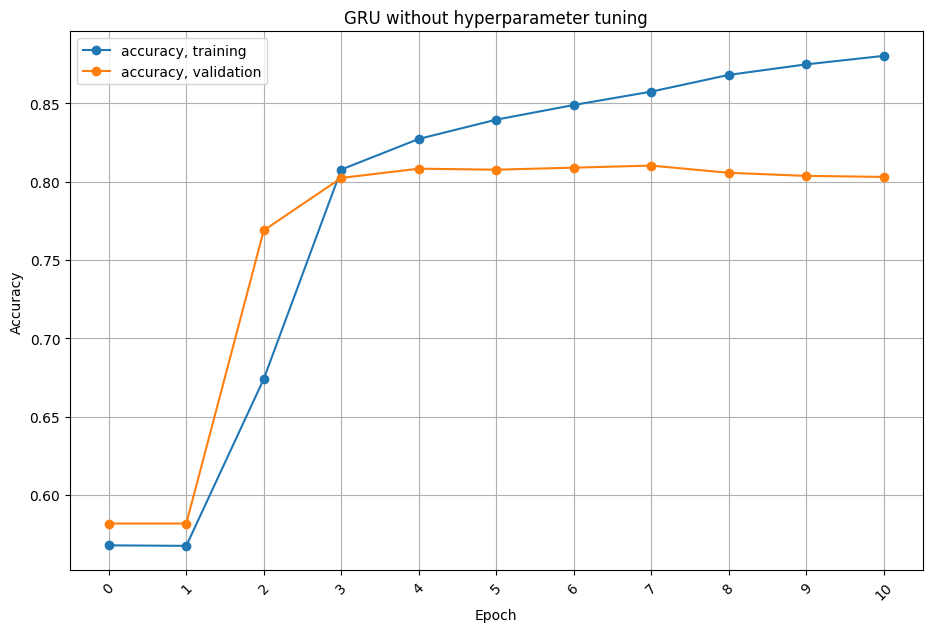

In [93]:
plot_accuracy(history, "GRU without hyperparameter tuning")

In [94]:
# save submission
y_test_pred = model.predict(padded_sequences_test)

102/102 [==============================] - 1s 6ms/step


In [95]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/GRU_no_tuning.csv", index=False)

48/48 [==============================] - 0s 4ms/step


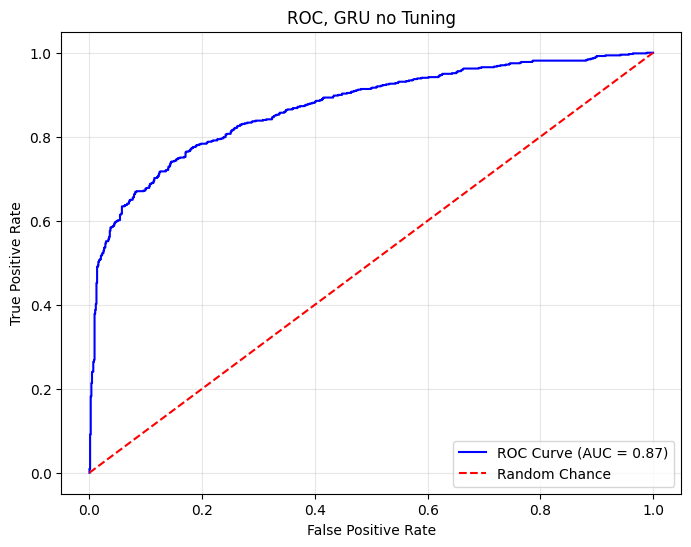

In [96]:
# plot ROC
y_pred_val = model.predict(X_test)
plot_roc(y_test.astype(int), y_pred_val, 'ROC, GRU no Tuning')

### LSTM without Hyperparameter Tuning

In [97]:
# build LSTM model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),

    LSTM(32, return_sequences=False, trainable=True),
    # Dropout(0.2),
    Dense(128, activation='relu', trainable=True),
    # Dropout(0.2),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 lstm_3 (LSTM)               (None, 32)                42624     
                                                                 
 dense_16 (Dense)            (None, 128)               4224      
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5475177 (20.89 MB)
Trainable params: 46977 (183.50 KB)
Non-trainable params: 5428200 (20.71 MB)
_________________________________________________________________


In [98]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
191/191 [==============================] - 5s 18ms/step - loss: 0.5349 - accuracy: 0.7383 - val_loss: 0.4815 - val_accuracy: 0.7840
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.4333 - accuracy: 0.8195 - val_loss: 0.4528 - val_accuracy: 0.8076
Epoch 3/100
191/191 [==============================] - 3s 14ms/step - loss: 0.4188 - accuracy: 0.8240 - val_loss: 0.4448 - val_accuracy: 0.8056
Epoch 4/100
191/191 [==============================] - 3s 15ms/step - loss: 0.4015 - accuracy: 0.8327 - val_loss: 0.4733 - val_accuracy: 0.8070
Epoch 5/100
191/191 [==============================] - 3s 15ms/step - loss: 0.3957 - accuracy: 0.8399 - val_loss: 0.4492 - val_accuracy: 0.7978
Epoch 6/100
191/191 [==============================] - 3s 14ms/step - loss: 0.3869 - accuracy: 0.8430 - val_loss: 0.4458 - val_accuracy: 0.8030
Epoch 7/100
191/191 [==============================] - 3s 18ms/step - loss: 0.3751 - accuracy: 0.8433 - val_loss: 0.4807 - val_accuracy:

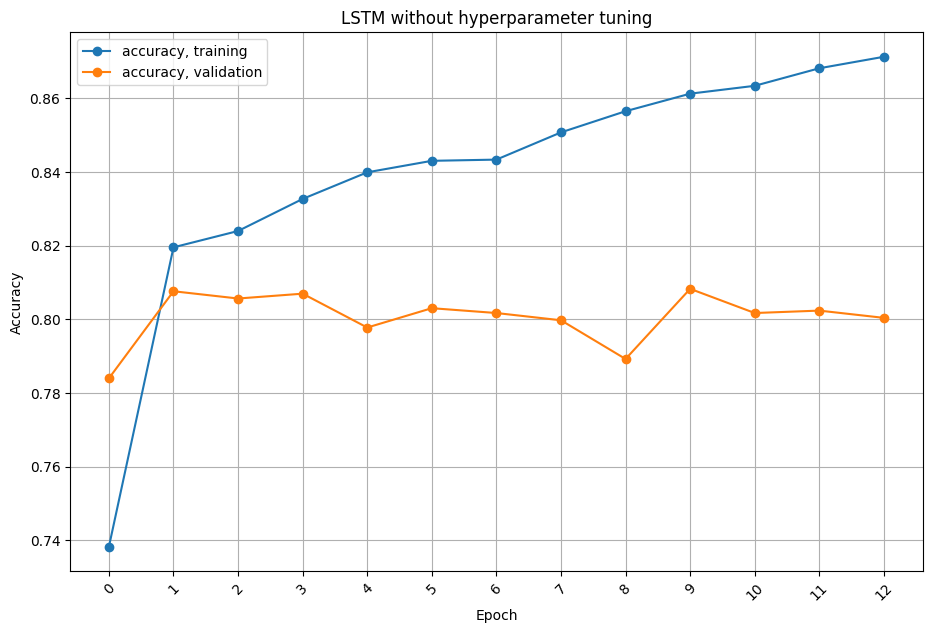

In [99]:
plot_accuracy(history, "LSTM without hyperparameter tuning")

In [100]:
# save submission
y_test_pred = model.predict(padded_sequences_test)

102/102 [==============================] - 1s 5ms/step


In [101]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/LSTM_no_tuning.csv", index=False)

48/48 [==============================] - 0s 6ms/step


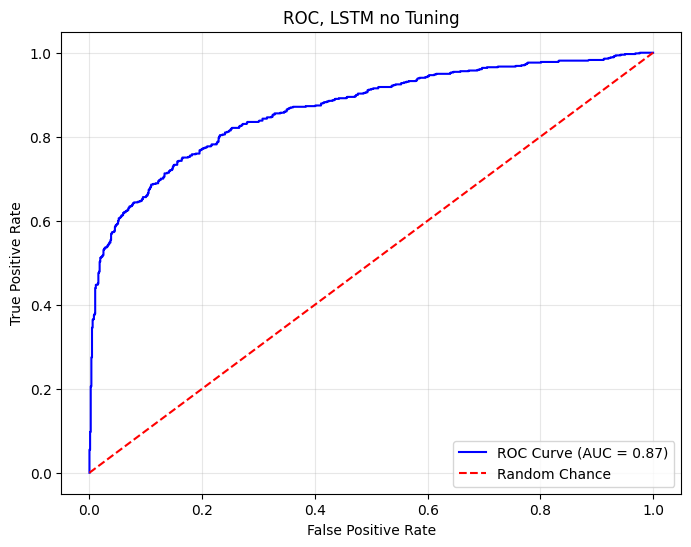

In [102]:
y_pred_val = model.predict(X_test)
plot_roc(y_test.astype(int), y_pred_val, 'ROC, LSTM no Tuning')

### LSTM with Hyperparameter Tuning

In [103]:
# build LSTM model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),

    LSTM(16, return_sequences=False, trainable=True),
    Dropout(0.2),
    Dense(128, activation='relu', trainable=True),
    Dropout(0.2),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 lstm_4 (LSTM)               (None, 16)                20288     
                                                                 
 dropout_230 (Dropout)       (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               2176      
                                                                 
 dropout_231 (Dropout)       (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5450793 (20.79 MB)
Trainable params: 225

In [104]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
191/191 [==============================] - 5s 18ms/step - loss: 0.6900 - accuracy: 0.5657 - val_loss: 0.6804 - val_accuracy: 0.5817
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.6188 - accuracy: 0.6826 - val_loss: 0.5521 - val_accuracy: 0.7708
Epoch 3/100
191/191 [==============================] - 3s 16ms/step - loss: 0.5327 - accuracy: 0.7823 - val_loss: 0.5131 - val_accuracy: 0.7820
Epoch 4/100
191/191 [==============================] - 3s 16ms/step - loss: 0.4943 - accuracy: 0.7980 - val_loss: 0.4957 - val_accuracy: 0.7833
Epoch 5/100
191/191 [==============================] - 3s 14ms/step - loss: 0.4732 - accuracy: 0.8069 - val_loss: 0.4810 - val_accuracy: 0.7965
Epoch 6/100
191/191 [==============================] - 3s 15ms/step - loss: 0.4606 - accuracy: 0.8072 - val_loss: 0.4703 - val_accuracy: 0.7997
Epoch 7/100
191/191 [==============================] - 3s 15ms/step - loss: 0.4464 - accuracy: 0.8153 - val_loss: 0.4641 - val_accuracy:

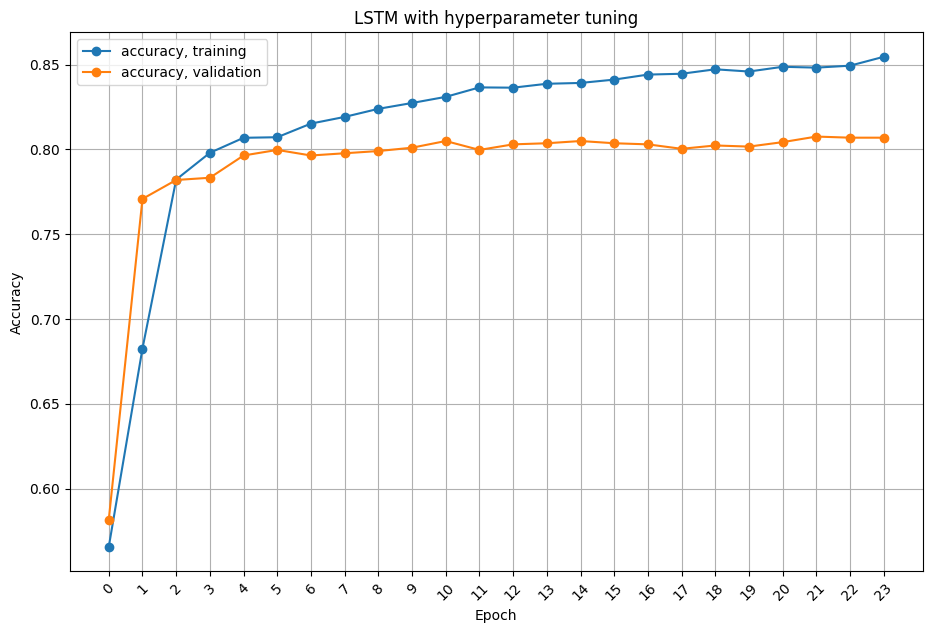

In [105]:
plot_accuracy(history, "LSTM with hyperparameter tuning")

In [106]:
# save submission
y_test_pred = model.predict(padded_sequences_test)

102/102 [==============================] - 1s 5ms/step


In [107]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/LSTM_with_tuning.csv", index=False)

48/48 [==============================] - 0s 5ms/step


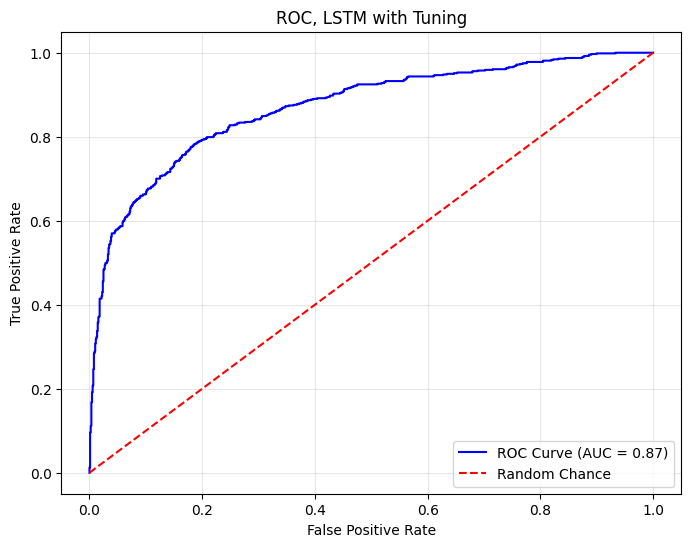

In [108]:
y_pred_val = model.predict(X_test)
plot_roc(y_test.astype(int), y_pred_val, 'ROC, LSTM with Tuning')

### Fine-Tuning Pretrained BERT

In [145]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [146]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], 
    train_df['target'],
    test_size=0.2,
    random_state=0
)

In [147]:
# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize the training and validation texts
train_encodings = tokenizer(
    list(train_texts),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf' 
)

val_encodings = tokenizer(
    list(val_texts),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_encodings = tokenizer(
    list(test_df['text']),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf' 
)

In [148]:
# convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels.tolist())
val_labels_original = val_labels # for ROC curve
val_labels = tf.convert_to_tensor(val_labels.tolist())

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}
)).batch(32)

In [149]:
# load and compile BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6,epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_307 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [150]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
191/191 [==============================] - 75s 239ms/step - loss: 0.6127 - accuracy: 0.6409 - val_loss: 0.5160 - val_accuracy: 0.7814
Epoch 2/100
191/191 [==============================] - 39s 204ms/step - loss: 0.4656 - accuracy: 0.8090 - val_loss: 0.4386 - val_accuracy: 0.8240
Epoch 3/100
191/191 [==============================] - 39s 205ms/step - loss: 0.4045 - accuracy: 0.8365 - val_loss: 0.4178 - val_accuracy: 0.8352
Epoch 4/100
191/191 [==============================] - 39s 203ms/step - loss: 0.3676 - accuracy: 0.8511 - val_loss: 0.4112 - val_accuracy: 0.8359
Epoch 5/100
191/191 [==============================] - 39s 206ms/step - loss: 0.3446 - accuracy: 0.8642 - val_loss: 0.4175 - val_accuracy: 0.8332
Epoch 6/100
191/191 [==============================] - 39s 202ms/step - loss: 0.3229 - accuracy: 0.8765 - val_loss: 0.4153 - val_accuracy: 0.8352
Epoch 7/100
191/191 [==============================] - 39s 204ms/step - loss: 0.3037 - accuracy: 0.8872 - val_loss: 0.4163 -

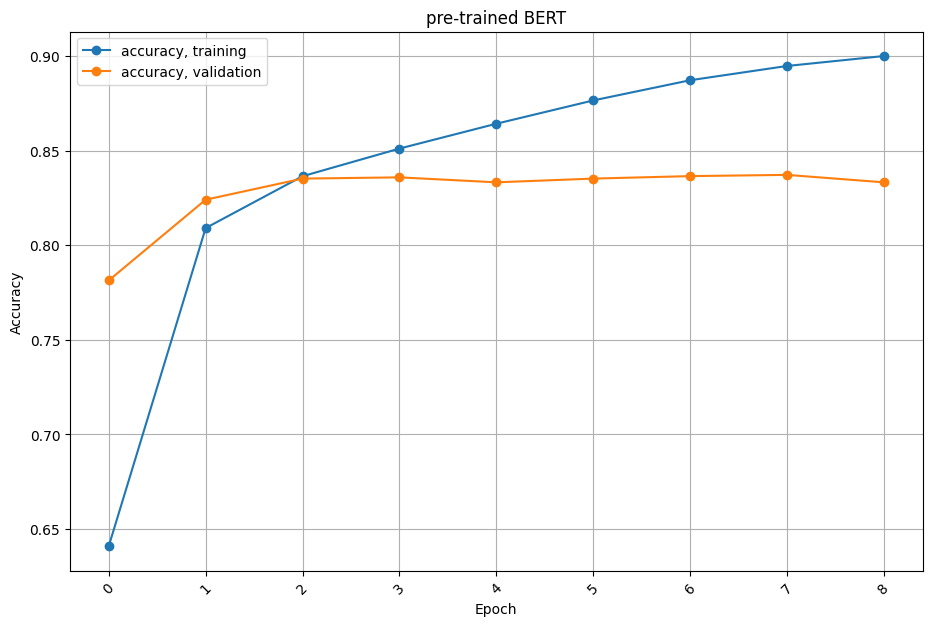

In [156]:
plot_accuracy(history, "pre-trained BERT")

In [157]:
predictions = model.predict(test_dataset)
probabilities = tf.nn.sigmoid(predictions.logits)
predicted_classes = tf.cast(probabilities > 0.5, dtype=tf.int32)

102/102 [==============================] - 9s 87ms/step


In [158]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = np.array(predicted_classes)

submission_df.to_csv("./submissions/BERT.csv", index=False)

48/48 [==============================] - 4s 88ms/step


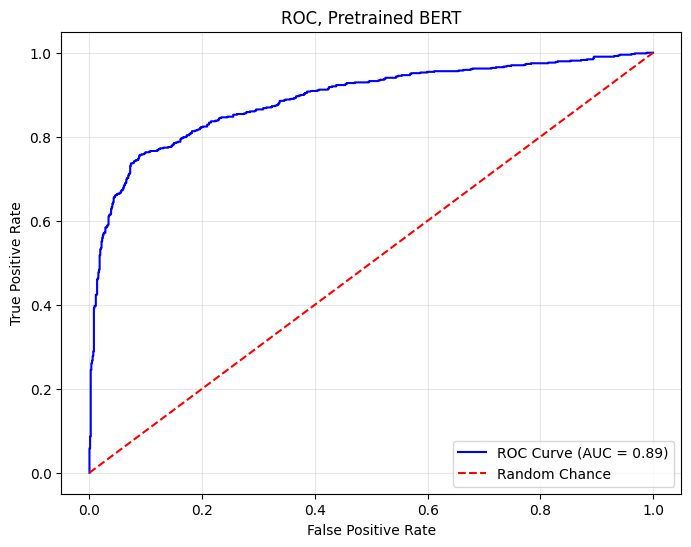

In [159]:
y_pred_val = model.predict(val_dataset)
y_pred_val = tf.nn.sigmoid(y_pred_val.logits)

plot_roc(val_labels_original, y_pred_val, 'ROC, Pretrained BERT')

## Results and Analysis

|Model|Optimal Val_Acc|AUC|Public Score|
|-:|:-:|:-:|:-:|
|GRU No Tuning|0.8102|0.87|0.80478|
|LSTM No Tuning|0.8083|0.87|0.80018|
|LSTM With Tuning|0.8076|0.87|0.79558|
|Pretrained BERT|0.8372|0.89|0.82194|

## Conclusion